# IPL Score Prediction

This notebook uses ball-by-ball data to train machine learning models for predicting the final score of an IPL innings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


## Load Dataset

In [2]:
df = pd.read_csv("ipl_colab.csv")
df.head()


,mid,date,venue,batting_team,bowling_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


## Data Overview

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76014 entries, 0 to 76013
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mid             76014 non-null  int64  
 1   date            76014 non-null  object 
 2   venue           76014 non-null  object 
 3   batting_team    76014 non-null  object 
 4   bowling_team    76014 non-null  object 
 5   batsman         76014 non-null  object 
 6   bowler          76014 non-null  object 
 7   runs            76014 non-null  int64  
 8   wickets         76014 non-null  int64  
 9   overs           76014 non-null  float64
 10  runs_last_5     76014 non-null  int64  
 11  wickets_last_5  76014 non-null  int64  
 12  striker         76014 non-null  int64  
 13  non-striker     76014 non-null  int64  
 14  total           76014 non-null  int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 8.7+ MB


In [4]:
df.describe()


,mid,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
count,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000
mean,308.627740,74.889349,2.415844,9.783068,33.216434,1.120307,24.962283,8.869287,160.901452
std,178.156878,48.823327,2.015207,5.772587,14.914174,1.053343,20.079752,10.795742,29.246231
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000
25%,154.000000,34.000000,1.000000,4.600000,24.000000,0.000000,10.000000,1.000000,142.000000
50%,308.000000,70.000000,2.000000,9.600000,34.000000,1.000000,20.000000,5.000000,162.000000
75%,463.000000,111.000000,4.000000,14.600000,43.000000,2.000000,35.000000,13.000000,181.000000
max,617.000000,263.000000,10.000000,19.600000,113.000000,7.000000,175.000000,109.000000,263.000000


## Data Visualization

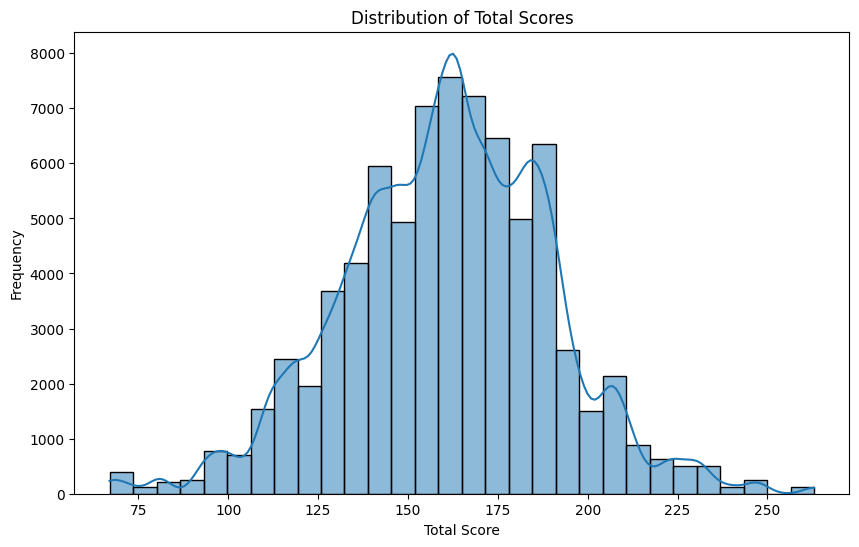

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(df['total'], bins=30, kde=True)
plt.title('Distribution of Total Scores')
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.show()


## Feature Engineering

In [6]:
df = df[['batting_team', 'bowling_team', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5', 'striker', 'non-striker', 'total']]

# Encode categorical features
df = pd.get_dummies(df, columns=['batting_team', 'bowling_team'])

df.head()


,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total,batting_team_Chennai Super Kings,batting_team_Deccan Chargers,...,bowling_team_Kings XI Punjab,bowling_team_Kochi Tuskers Kerala,bowling_team_Kolkata Knight Riders,bowling_team_Mumbai Indians,bowling_team_Pune Warriors,bowling_team_Rajasthan Royals,bowling_team_Rising Pune Supergiant,bowling_team_Rising Pune Supergiants,bowling_team_Royal Challengers Bangalore,bowling_team_Sunrisers Hyderabad
0,1,0,0.1,1,0,0,0,222,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0.2,1,0,0,0,222,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2,0,0.2,2,0,0,0,222,False,False,...,False,False,False,False,False,False,False,False,True,False
3,2,0,0.3,2,0,0,0,222,False,False,...,False,False,False,False,False,False,False,False,True,False
4,2,0,0.4,2,0,0,0,222,False,False,...,False,False,False,False,False,False,False,False,True,False


## Train-Test Split

In [7]:
X = df.drop('total', axis=1)
y = df['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Training and Comparison

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
results_df


,MAE,RMSE,R2 Score
Linear Regression,14.660474,19.678058,0.540925
Random Forest,5.044592,9.417891,0.894846
XGBoost,10.509188,14.800413,0.740303


## Model Performance Comparison

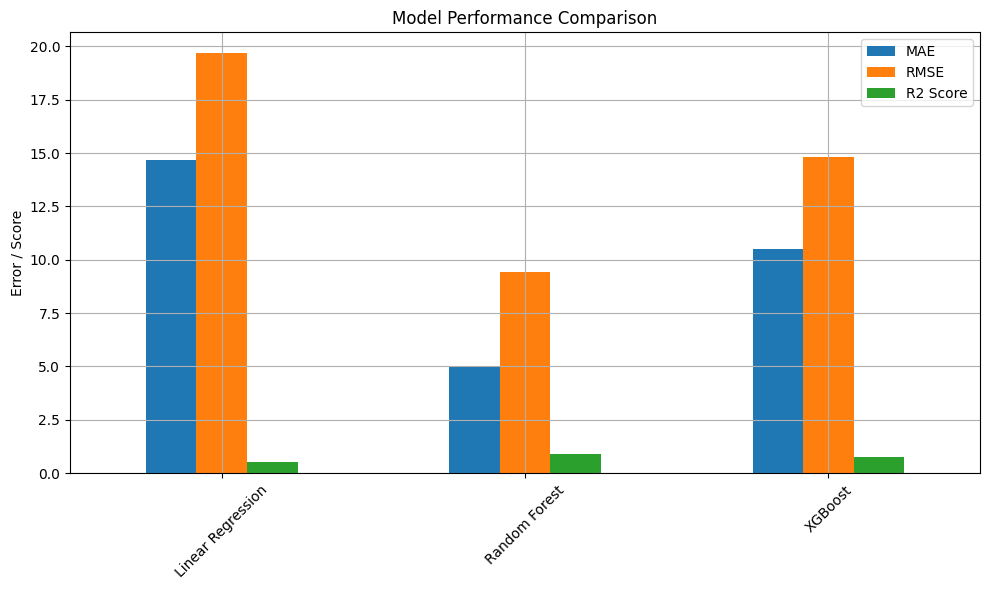

In [9]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Error / Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## (Optional) Save Best Model

In [10]:
# Example: Save the best model (e.g., XGBoost)
import joblib
joblib.dump(models['XGBoost'], 'xgb_model.pkl')


['xgb_model.pkl']